# **Giới thiệu**

Trong bài này, chúng ta xây dựng một **pipeline học máy hoàn chỉnh** cho bài toán phân loại bệnh tim.  
Pipeline bao gồm các bước: EDA, tiền xử lý dữ liệu, trích xuất & lựa chọn đặc trưng, huấn luyện nhiều mô hình, đánh giá theo các chỉ số (Accuracy, Precision, Recall, F1-score), và trực quan hóa kết quả.  

Bộ dữ liệu sử dụng được lấy từ Kaggle:  
- [Heart Disease Dataset – oktayrdeki](https://www.kaggle.com/datasets/oktayrdeki/heart-disease)  

Toàn bộ nội dung cùng các Assignment khác trong môn **Machine Learning – HK251** được tổng hợp tại:  
- [Trang tổng hợp Machine Learning – Nhóm DNA05](https://nhinguyen140809.github.io/ml-asm-dna05/)  

Dưới đây là phần cài đặt và import các thư viện cần thiết để bắt đầu thực nghiệm.


# **Cài đặt và Import Thư viện**
Trong bước này, chúng ta sẽ:
- Cài đặt các thư viện cần thiết cho pipeline học máy.
- Import đầy đủ các module phục vụ cho **EDA, tiền xử lý, trích xuất đặc trưng, huấn luyện và đánh giá mô hình**.
- Thiết lập một số cấu hình cơ bản (ví dụ: tắt cảnh báo không quan trọng để log gọn gàng hơn).

Lưu ý:
- Người dùng có thể thêm/bớt thư viện nếu mở rộng pipeline (ví dụ: deep learning)
- Nếu notebook đã có sẵn môi trường, có thể bỏ qua lệnh `!pip install`.

In [1]:
# ============================================================
# Cài đặt thư viện cần thiết
# ============================================================
!pip install kagglehub plotly scikit-learn imbalanced-learn -q

# ============================================================
# Import các thư viện
# ============================================================

# Xử lý hệ thống & dữ liệu
import os
import warnings
import numpy as np
import pandas as pd

# Trực quan hóa
import plotly.express as px
import matplotlib.pyplot as plt

# Tiền xử lý dữ liệu
from sklearn.preprocessing import (
    OrdinalEncoder, LabelEncoder,
    StandardScaler, MinMaxScaler
)
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV

# Mô hình học máy
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# Pipeline & Feature Extraction
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Đánh giá mô hình
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)

# Xử lý mất cân bằng dữ liệu
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Hỗ trợ hiển thị
from IPython.display import display

# Kaggle dataset downloader
import kagglehub

# Thiết lập hiển thị & warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:.3f}".format)

# Dùng modules

#!rm -rf ml-asm-dna05                                               # Comment dòng này khi chạy Local
#!git clone -q https://github.com/nhinguyen140809/ml-asm-dna05.git  # Comment dòng này khi chạy Local
import sys
#sys.path.append("ml-asm-dna05/modules")                            # Comment dòng này khi chạy Local
sys.path.append("../modules")                             # Uncomment dòng này khi chạy Local
from ml_pipeline import search_best_model, download_kaggle_dataset



print("Import và cài đặt thư viện thành công!")

Import và cài đặt thư viện thành công!


# **Tải Dataset**

Trong bước này, chúng ta sẽ:
- Tải **Heart Disease Dataset** từ Kaggle thông qua `kagglehub`.
- Thiết lập cách xử lý giá trị thiếu (`na_values`) để dữ liệu được chuẩn hóa ngay từ đầu.

Cấu hình có thể thay đổi:
- `DATASET_NAME`: Tên dataset trên Kaggle (có thể thay đổi sang dataset khác).
- `FILE_EXTENSION`: Phần mở rộng của file dữ liệu cần đọc (mặc định `.csv`).
- `NA_VALUES`: Các giá trị coi là missing (có thể thêm `"NA"`, `"?"` nếu dataset khác).

In [2]:
# ============================================================
# Cấu hình tải dataset
# ============================================================
CONFIG = {
    "DATASET_NAME": "oktayrdeki/heart-disease",  # Thay đổi nếu muốn dùng dataset khác
    "FILE_EXTENSION": ".csv",                    # Có thể đổi sang .xlsx nếu cần
    "NA_VALUES": ["", np.nan]                    # Các giá trị coi là missing
}

# ============================================================
# Đọc dữ liệu vào DataFrame
# ============================================================

csv_path = download_kaggle_dataset(CONFIG["DATASET_NAME"], CONFIG["FILE_EXTENSION"])

df = pd.read_csv(
    csv_path,
    keep_default_na=False,
    na_values=CONFIG["NA_VALUES"]
)

print("Dataset loaded thành công!")
display(df.head())


Using Colab cache for faster access to the 'heart-disease' dataset.
Dataset downloaded to: /kaggle/input/heart-disease
Dataset loaded thành công!


,Age,Gender,Blood Pressure,Cholesterol Level,Exercise Habits,Smoking,Family Heart Disease,Diabetes,BMI,High Blood Pressure,Low HDL Cholesterol,High LDL Cholesterol,Alcohol Consumption,Stress Level,Sleep Hours,Sugar Consumption,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level,Heart Disease Status
0,56.000,Male,153.000,155.000,High,Yes,Yes,No,24.992,Yes,Yes,No,High,Medium,7.633,Medium,342.000,NaN,12.969,12.387,No
1,69.000,Female,146.000,286.000,High,No,Yes,Yes,25.222,No,Yes,No,Medium,High,8.744,Medium,133.000,157.000,9.355,19.299,No
2,46.000,Male,126.000,216.000,Low,No,No,No,29.855,No,Yes,Yes,Low,Low,4.440,Low,393.000,92.000,12.710,11.231,No
3,32.000,Female,122.000,293.000,High,Yes,Yes,No,24.130,Yes,No,Yes,Low,High,5.249,High,293.000,94.000,12.509,5.962,No
4,60.000,Male,166.000,242.000,Low,Yes,Yes,Yes,20.486,Yes,No,No,Low,High,7.031,High,263.000,154.000,10.381,8.154,No


# **1. EDA – Exploratory Data Analysis**


## 1.1. Tổng quan dữ liệu  

Trong bước này, chúng ta sẽ:  
- Hiển thị **5 dòng đầu tiên** để có cái nhìn nhanh về cấu trúc dữ liệu.  
- Tạo bảng **tổng quan dataset**: kiểu dữ liệu, số lượng non-null, số lượng null, số giá trị unique.  
- Thống kê **missing values** cho từng cột.  
- Sinh **summary statistics** riêng cho **numeric** và **categorical** columns.  

Cấu hình có thể thay đổi:
- `N_HEAD`: số dòng muốn hiển thị ở đầu dataset.  
- Có thể bật/tắt hiển thị từng bảng bằng các flag `SHOW_NUMERIC_SUMMARY`, `SHOW_CATEGORICAL_SUMMARY`.  

In [3]:
# ============================================================
# Cấu hình EDA
# ============================================================
EDA_CONFIG = {
    "N_HEAD": 5,                     # Số dòng đầu hiển thị
    "SHOW_NUMERIC_SUMMARY": True,    # Bật/tắt thống kê numeric
    "SHOW_CATEGORICAL_SUMMARY": True # Bật/tắt thống kê categorical
}

# ============================================================
# Hiển thị 5 dòng đầu tiên
# ============================================================
display(df.head(EDA_CONFIG["N_HEAD"]).style.set_caption(f"{EDA_CONFIG['N_HEAD']} dòng đầu tiên"))
print("\n\n")

# ============================================================
# Tổng quan dataset
# ============================================================
overview = pd.DataFrame({
    "Dtype": df.dtypes,
    "Non-Null Count": df.notnull().sum(),
    "Null Count": df.isnull().sum(),
    "Unique Values": df.nunique()
})
display(overview.style.set_caption("Tổng quan Dataset"))
print("\n\n")

# ============================================================
# Thống kê Missing Values
# ============================================================
missing = df.isnull().sum().sort_values(ascending=False)
if missing.sum() > 0:
    display(missing.to_frame("Số lượng missing").style.set_caption("Thống kê Missing Values"))
else:
    print("Không có missing values trong dataset.")
print("\n\n")

# ============================================================
# Numeric summary
# ============================================================
if EDA_CONFIG["SHOW_NUMERIC_SUMMARY"]:
    num_summary = df.describe().T
    if not num_summary.empty:
        display(num_summary.style.set_caption("Thống kê Numeric Columns"))
print("\n\n")

# ============================================================
# Categorical summary
# ============================================================
if EDA_CONFIG["SHOW_CATEGORICAL_SUMMARY"]:
    cat_summary = df.describe(include=['object', 'category']).T
    if not cat_summary.empty:
        display(cat_summary.style.set_caption("Thống kê Categorical Columns"))


,Age,Gender,Blood Pressure,Cholesterol Level,Exercise Habits,Smoking,Family Heart Disease,Diabetes,BMI,High Blood Pressure,Low HDL Cholesterol,High LDL Cholesterol,Alcohol Consumption,Stress Level,Sleep Hours,Sugar Consumption,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level,Heart Disease Status
0,56.000000,Male,153.000000,155.000000,High,Yes,Yes,No,24.991591,Yes,Yes,No,High,Medium,7.633228,Medium,342.000000,nan,12.969246,12.387250,No
1,69.000000,Female,146.000000,286.000000,High,No,Yes,Yes,25.221799,No,Yes,No,Medium,High,8.744034,Medium,133.000000,157.000000,9.355389,19.298875,No
2,46.000000,Male,126.000000,216.000000,Low,No,No,No,29.855447,No,Yes,Yes,Low,Low,4.440440,Low,393.000000,92.000000,12.709873,11.230926,No
3,32.000000,Female,122.000000,293.000000,High,Yes,Yes,No,24.130477,Yes,No,Yes,Low,High,5.249405,High,293.000000,94.000000,12.509046,5.961958,No
4,60.000000,Male,166.000000,242.000000,Low,Yes,Yes,Yes,20.486289,Yes,No,No,Low,High,7.030971,High,263.000000,154.000000,10.381259,8.153887,No


,Dtype,Non-Null Count,Null Count,Unique Values
Age,float64,9971,29,63
Gender,object,9981,19,2
Blood Pressure,float64,9981,19,61
Cholesterol Level,float64,9970,30,151
Exercise Habits,object,9975,25,3
Smoking,object,9975,25,2
Family Heart Disease,object,9979,21,2
Diabetes,object,9970,30,2
BMI,float64,9978,22,9978
High Blood Pressure,object,9974,26,2


,Số lượng missing
Alcohol Consumption,32
Diabetes,30
Sugar Consumption,30
Cholesterol Level,30
Age,29
Triglyceride Level,26
CRP Level,26
High LDL Cholesterol,26
High Blood Pressure,26
Low HDL Cholesterol,25


,count,mean,std,min,25%,50%,75%,max
Age,9971.000000,49.296259,18.193970,18.000000,34.000000,49.000000,65.000000,80.000000
Blood Pressure,9981.000000,149.757740,17.572969,120.000000,134.000000,150.000000,165.000000,180.000000
Cholesterol Level,9970.000000,225.425577,43.575809,150.000000,187.000000,226.000000,263.000000,300.000000
BMI,9978.000000,29.077269,6.307098,18.002837,23.658075,29.079492,34.520015,39.996954
Sleep Hours,9975.000000,6.991329,1.753195,4.000605,5.449866,7.003252,8.531577,9.999952
Triglyceride Level,9974.000000,250.734409,87.067226,100.000000,176.000000,250.000000,326.000000,400.000000
Fasting Blood Sugar,9978.000000,120.142213,23.584011,80.000000,99.000000,120.000000,141.000000,160.000000
CRP Level,9974.000000,7.472201,4.340248,0.003647,3.674126,7.472164,11.255592,14.997087
Homocysteine Level,9980.000000,12.456271,4.323426,5.000236,8.723334,12.409395,16.140564,19.999037


,count,unique,top,freq
Gender,9981,2,Male,5003
Exercise Habits,9975,3,High,3372
Smoking,9975,2,Yes,5123
Family Heart Disease,9979,2,No,5004
Diabetes,9970,2,No,5018
High Blood Pressure,9974,2,Yes,5022
Low HDL Cholesterol,9975,2,Yes,5000
High LDL Cholesterol,9974,2,No,5036
Alcohol Consumption,9968,4,None,2554
Stress Level,9978,3,Medium,3387


## **1.2. Thống kê tần suất nhãn**

Ở bước này, ta sẽ:  
- Đếm tần suất xuất hiện của từng nhãn trong cột **`Heart Disease Status`**.  
- Trực quan hoá bằng **biểu đồ cột** (bar chart).  

Cấu hình có thể thay đổi:  
- `LABEL_COL`: tên cột nhãn cần thống kê.  
- `BAR_COLOR`: chọn palette hiển thị (nếu muốn đồng bộ màu sắc).  
- `SHOW_PERCENTAGE`: hiển thị tỷ lệ % thay vì/together với số lượng tuyệt đối.  


In [4]:
# ============================================================
# Cấu hình thống kê nhãn
# ============================================================
LABEL_CONFIG = {
    "LABEL_COL": "Heart Disease Status",  # Tên cột nhãn
    "SHOW_PERCENTAGE": True               # Hiển thị thêm % trên biểu đồ
}

# ============================================================
# Thống kê tần suất nhãn
# ============================================================
label_col = LABEL_CONFIG["LABEL_COL"]

label_counts = df[label_col].value_counts().reset_index()
label_counts.columns = [label_col, "Count"]

# Nếu cần hiển thị thêm %:
if LABEL_CONFIG["SHOW_PERCENTAGE"]:
    total = label_counts["Count"].sum()
    label_counts["Percentage"] = (label_counts["Count"] / total * 100).round(2)

# ============================================================
# Biểu đồ tần suất nhãn
# ============================================================
fig = px.bar(
    label_counts,
    x=label_col,
    y="Count",
    text="Count" if not LABEL_CONFIG["SHOW_PERCENTAGE"] else label_counts.apply(
        lambda r: f"{r['Count']} ({r['Percentage']}%)", axis=1
    ),
    color=label_col,
    title=f"Thống kê tần suất nhãn: {label_col}"
)

fig.update_traces(textposition="outside")
fig.update_layout(showlegend=False, xaxis_title=label_col, yaxis_title="Count")
fig.show()


## 1.3. Thống kê mô tả cho Numeric Columns  

Ở bước này ta sẽ:  
- Lọc ra các cột **numeric**.
- Tạo bảng thống kê mô tả (mean, std, min, max, quartiles).  
- Trực quan hoá phân phối bằng **histogram kèm boxplot** để phát hiện phân phối và outliers.  

Cấu hình có thể thay đổi:  
- `NUMERIC_BINS`: số lượng bins trong histogram.  
- `SHOW_BOXPLOT`: có hiển thị boxplot phụ không.  
- `HIST_COLOR`: màu histogram.  


In [5]:
# ============================================================
# Cấu hình thống kê numeric
# ============================================================
NUMERIC_CONFIG = {
    "NUMERIC_BINS": 30,            # Số bins trong histogram
    "SHOW_BOXPLOT": True,          # Hiển thị boxplot trên histogram
    "HIST_COLOR": "dodgerblue"     # Màu sắc histogram
}

# ============================================================
# Lọc numeric columns
# ============================================================
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# ============================================================
# Thống kê mô tả
# ============================================================
if numeric_cols:
    display(df[numeric_cols].describe().T.style.set_caption("Thống kê Numeric Columns"))
else:
    print("Không có numeric columns trong dataset.")

# ============================================================
# Trực quan phân phối numeric
# ============================================================
for col in numeric_cols:
    fig = px.histogram(
        df,
        x=col,
        nbins=NUMERIC_CONFIG["NUMERIC_BINS"],
        title=f"Phân phối {col}",
        marginal="box" if NUMERIC_CONFIG["SHOW_BOXPLOT"] else None,
        color_discrete_sequence=[NUMERIC_CONFIG["HIST_COLOR"]]
    )
    fig.update_layout(yaxis_title="Số lượng mẫu", bargap=0.05)
    fig.show()


,count,mean,std,min,25%,50%,75%,max
Age,9971.000000,49.296259,18.193970,18.000000,34.000000,49.000000,65.000000,80.000000
Blood Pressure,9981.000000,149.757740,17.572969,120.000000,134.000000,150.000000,165.000000,180.000000
Cholesterol Level,9970.000000,225.425577,43.575809,150.000000,187.000000,226.000000,263.000000,300.000000
BMI,9978.000000,29.077269,6.307098,18.002837,23.658075,29.079492,34.520015,39.996954
Sleep Hours,9975.000000,6.991329,1.753195,4.000605,5.449866,7.003252,8.531577,9.999952
Triglyceride Level,9974.000000,250.734409,87.067226,100.000000,176.000000,250.000000,326.000000,400.000000
Fasting Blood Sugar,9978.000000,120.142213,23.584011,80.000000,99.000000,120.000000,141.000000,160.000000
CRP Level,9974.000000,7.472201,4.340248,0.003647,3.674126,7.472164,11.255592,14.997087
Homocysteine Level,9980.000000,12.456271,4.323426,5.000236,8.723334,12.409395,16.140564,19.999037


## 1.4. Thống kê mô tả cho Categorical Columns  

Ở bước này ta sẽ:  
- Lọc ra các **categorical columns** (ngoại trừ cột target `Heart Disease Status`).  
- Tính tần suất xuất hiện của từng giá trị.  
- Trực quan hoá bằng **pie chart** để thấy cơ cấu phân bố.  

Cấu hình có thể thay đổi:  
- `SHOW_LIMIT`: số lượng category tối đa sẽ hiển thị (giúp tránh pie chart quá rối với nhiều nhãn).  
- `PIE_TEXTINFO`: dạng thông tin hiển thị trên chart (`"percent"`, `"value"`, `"percent+value"`, …).  
- `PIE_HOLE`: hệ số donut (0 = pie chart thường, >0 = donut chart).  


In [6]:
# ============================================================
# Cấu hình thống kê categorical
# ============================================================
CATEGORICAL_CONFIG = {
    "SHOW_LIMIT": 10,                   # Hiển thị tối đa bao nhiêu category (None = tất cả)
    "PIE_TEXTINFO": "percent+value",    # Hiển thị % và số lượng
    "PIE_HOLE": 0.0,                    # 0 = pie chart thường, >0 = donut chart
    "LABEL_COL": "Heart Disease Status" # Tên cột nhãn
}

# ============================================================
# Lọc categorical columns (bỏ target)
# ============================================================
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != LABEL_CONFIG["LABEL_COL"]]

# ============================================================
# Thống kê và trực quan hóa categorical
# ============================================================
if categorical_cols:
    for col in categorical_cols:
        counts = df[col].value_counts().reset_index()
        counts.columns = [col, "Count"]

        # Giới hạn số lượng category hiển thị
        if CATEGORICAL_CONFIG["SHOW_LIMIT"] is not None:
            counts = counts.head(CATEGORICAL_CONFIG["SHOW_LIMIT"])

        fig = px.pie(
            counts,
            names=col,
            values="Count",
            title=f"Cơ cấu {col}",
            hole=CATEGORICAL_CONFIG["PIE_HOLE"]
        )
        fig.update_traces(textinfo=CATEGORICAL_CONFIG["PIE_TEXTINFO"])
        fig.show()
else:
    print("Không có categorical columns trong dataset.")


# **2. Tiền xử lý dữ liệu**

## 2.0. (Tuỳ chọn) Load đặc trưng đã xử lý sẵn (Preprocessed Features)

- **Mục đích:**  
  - Cho phép người dùng chạy trực tiếp **Phần 4 – Học máy**, mà không cần chạy lại toàn bộ các cell tiền xử lý và áp dụng PCA trong pipeline huấn luyện.
  
- **Nguyên tắc hoạt động:**  
  - `USE_PREPROCESSED = False` → cần phải chạy tất cả các cell ở các phần bên dưới: **mục 2.1** đến **mục 2.5** (mặc định khi run all).  
  - `USE_PREPROCESSED = True` → load dữ liệu từ thư mục `features/`.  
    - Dữ liệu đã xử lý bao gồm: toàn bộ tập dữ liệu đã tiền xử lý (không PCA) và các vector PCA ở các mức 70%, 80%, 90%, 99%.
  - Cả nhãn train/test được lưu kèm.
  - Ngay sau khi load, có thể chuyển thẳng đến **Phần 4 – Học máy**.

- **Lưu ý:**

  - Các bước tiền xử lý khác (scaling, SMOTE, encoding) không cần chạy nếu bật `USE_PREPROCESSED=True` và cần chuyển đến **Phần 4 – Học máy**.

  - Định dạng lưu: `.npy`.

  - Cần chọn mức `PCA_LEVEL` muốn load (gồm các mức **70, 80, 90, 99**(%) và **None** - tức không qua PCA)

### ⚠️ Lưu ý khi dùng dữ liệu đã xử lý sẵn (Preprocessed Features)
- Nếu load đặc trưng từ `features/`, các bước tiếp theo phải được chạy thủ công vì cần bỏ qua một số cell, điều chỉnh các giá trị cho phù hợp theo đúng **hướng dẫn** ở từng ô bên dưới.

In [7]:
# ============================================================
# Option: Load preprocessed feature embeddings
# ============================================================
USE_PREPROCESSED = False  # True: load dữ liệu đã xử lý sẵn, False: dùng kết quả từ preprocessing cell bên dưới

features_path = "ml-asm-dna05/features"
PCA_LEVEL = 90  # Chọn mức PCA để load (None = không dùng PCA, 70/80/90/99)

if USE_PREPROCESSED:
    print(f"Loading preprocessed feature embeddings (PCA={PCA_LEVEL if PCA_LEVEL else 'no PCA'}) from '{features_path}' ...")

    fname_prefix = f"features_pca_{PCA_LEVEL}" if PCA_LEVEL else "features_no_pca"

    # Load X/y train/test
    X_train = np.load(os.path.join(features_path, f"{fname_prefix}_X_train.npy"))
    X_test  = np.load(os.path.join(features_path, f"{fname_prefix}_X_test.npy"))
    y_train = np.load(os.path.join(features_path, f"{fname_prefix}_y_train.npy"))
    y_test  = np.load(os.path.join(features_path, f"{fname_prefix}_y_test.npy"))

    print("Loaded successfully!")
    print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

    # Thống kê nhãn
    unique, counts = np.unique(y_train, return_counts=True)
    print("\nTrain label distribution:")
    for u, c in zip(unique, counts):
        print(f"  Class {u}: {c}")

    unique, counts = np.unique(y_test, return_counts=True)
    print("\nTest label distribution:")
    for u, c in zip(unique, counts):
        print(f"  Class {u}: {c}")

    print("\nHãy chuyển trực tiếp đến Phần 4 – Học máy (Huấn luyện & đánh giá mô hình).")
else:
    print("Không load dữ liệu đã xử lý. Thực hiện các bước tiền xử lý dữ liệu ở các cell bên dưới (SMOTE, scaling, ...)")


Không load dữ liệu đã xử lý. Thực hiện các bước tiền xử lý dữ liệu ở các cell bên dưới (SMOTE, scaling, ...)



## 2.1. Encoding  

Ở bước này ta cần:  
1. **Định nghĩa thứ tự cho các biến categorical** (Ordinal Encoding).  
   - Một số biến có mức độ (`Low < Medium < High`).  
   - Một số biến boolean (`Yes/No`).  
   - Giới tính (`Male/Female`)
2. **Áp dụng `OrdinalEncoder`** cho các cột categorical.  
   - Bỏ qua giá trị missing (sẽ xử lý sau bằng KNN Imputer).  
3. **Encode target label** (`Heart Disease Status`) bằng `LabelEncoder`.  

Cấu hình có thể thay đổi:  
- `CATEGORY_MAP`: định nghĩa thứ tự cho từng nhóm biến.  
- `TARGET_COLUMN`: tên cột target.  


In [8]:
# ============================================================
# Lọc numeric & categorical columns (bỏ target)
# ============================================================
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != LABEL_CONFIG["LABEL_COL"]]

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# ============================================================
# Cấu hình encoding
# ============================================================
CATEGORY_MAP = {
    "Exercise Habits": ["Low", "Medium", "High"],
    "Stress Level": ["Low", "Medium", "High"],
    "Sugar Consumption": ["Low", "Medium", "High"],
    "Alcohol Consumption": ["None", "Low", "Medium", "High"],
    "Gender": ["Male", "Female"],
    # Các cột boolean khác (No/Yes)
}
DEFAULT_BOOLEAN = ["No", "Yes"]

TARGET_COLUMN = "Heart Disease Status"

# ============================================================
# Build categories list cho OrdinalEncoder
# ============================================================
categories = []
for col in categorical_cols:
    if col in CATEGORY_MAP:
        categories.append(CATEGORY_MAP[col])
    else:
        categories.append(DEFAULT_BOOLEAN)

# ============================================================
# Encode categorical columns bằng OrdinalEncoder
# ============================================================
for col, cats in zip(categorical_cols, categories):
    ordinal_encoder = OrdinalEncoder(categories=[cats])
    mask = df[col].notna()   # Bỏ qua missing
    df.loc[mask, col] = ordinal_encoder.fit_transform(df.loc[mask, [col]])

# ============================================================
# Encode target bằng LabelEncoder
# ============================================================
label_encoder = LabelEncoder()
df[TARGET_COLUMN] = label_encoder.fit_transform(df[TARGET_COLUMN])

# ============================================================
# Kiểm tra dữ liệu sau khi mã hoá
# ============================================================
display(df.head().style.set_caption("Dataset sau khi Encoding"))


,Age,Gender,Blood Pressure,Cholesterol Level,Exercise Habits,Smoking,Family Heart Disease,Diabetes,BMI,High Blood Pressure,Low HDL Cholesterol,High LDL Cholesterol,Alcohol Consumption,Stress Level,Sleep Hours,Sugar Consumption,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level,Heart Disease Status
0,56.000000,0.000000,153.000000,155.000000,2.000000,1.000000,1.000000,0.000000,24.991591,1.000000,1.000000,0.000000,3.000000,1.000000,7.633228,1.000000,342.000000,nan,12.969246,12.387250,0
1,69.000000,1.000000,146.000000,286.000000,2.000000,0.000000,1.000000,1.000000,25.221799,0.000000,1.000000,0.000000,2.000000,2.000000,8.744034,1.000000,133.000000,157.000000,9.355389,19.298875,0
2,46.000000,0.000000,126.000000,216.000000,0.000000,0.000000,0.000000,0.000000,29.855447,0.000000,1.000000,1.000000,1.000000,0.000000,4.440440,0.000000,393.000000,92.000000,12.709873,11.230926,0
3,32.000000,1.000000,122.000000,293.000000,2.000000,1.000000,1.000000,0.000000,24.130477,1.000000,0.000000,1.000000,1.000000,2.000000,5.249405,2.000000,293.000000,94.000000,12.509046,5.961958,0
4,60.000000,0.000000,166.000000,242.000000,0.000000,1.000000,1.000000,1.000000,20.486289,1.000000,0.000000,0.000000,1.000000,2.000000,7.030971,2.000000,263.000000,154.000000,10.381259,8.153887,0


## 2.2. Chia tập Train - Test  

Ở bước này ta sẽ:  
- Tách **features (X)** và **target (y)**.  
- Chia dữ liệu thành **train/test** để huấn luyện và đánh giá mô hình.  
- Dùng `stratify=y` để giữ phân phối nhãn đồng đều giữa train/test.  

Cấu hình có thể thay đổi:  
- `TARGET_COLUMN`: tên cột target.  
- `TEST_SIZE`: tỷ lệ dữ liệu cho tập test (0.2 = 20%).  
- `RANDOM_STATE`: seed để đảm bảo reproducibility.  

In [9]:
# ============================================================
# Cấu hình train-test split
# ============================================================
TARGET_COLUMN = "Heart Disease Status"
TEST_SIZE = 0.2
RANDOM_STATE = 42

# ============================================================
# Tách features và target
# ============================================================
X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]

# ============================================================
# Chia train - test
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

# ============================================================
# Kiểm tra kết quả
# ============================================================
print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")
print("\n\n")
display(y_train.value_counts().to_frame("Count").style.set_caption("Label Distribution - Train"))
print("\n\n")
display(y_test.value_counts().to_frame("Count").style.set_caption("Label Distribution - Test"))

# Xem vài dòng dữ liệu train
display(X_train.head().style.set_caption("5 dòng đầu tiên - Train set"))
print("\n\n")

# Xem vài dòng dữ liệu test
display(X_test.head().style.set_caption("5 dòng đầu tiên - Test set"))

Train samples: 8000, Test samples: 2000





,Count
Heart Disease Status,
0,6400
1,1600


,Count
Heart Disease Status,
0,1600
1,400


,Age,Gender,Blood Pressure,Cholesterol Level,Exercise Habits,Smoking,Family Heart Disease,Diabetes,BMI,High Blood Pressure,Low HDL Cholesterol,High LDL Cholesterol,Alcohol Consumption,Stress Level,Sleep Hours,Sugar Consumption,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level
7395,19.000000,0.000000,175.000000,272.000000,2.000000,0.000000,1.000000,0.000000,28.879776,1.000000,1.000000,0.000000,1.000000,0.000000,9.336435,2.000000,201.000000,159.000000,5.826202,17.965483
5642,22.000000,1.000000,123.000000,170.000000,2.000000,0.000000,0.000000,0.000000,30.256079,0.000000,1.000000,1.000000,2.000000,2.000000,nan,0.000000,335.000000,122.000000,3.209347,7.662533
8866,45.000000,1.000000,158.000000,172.000000,1.000000,1.000000,1.000000,1.000000,33.965395,1.000000,0.000000,1.000000,0.000000,1.000000,8.946560,0.000000,377.000000,109.000000,13.295242,19.739923
8517,29.000000,0.000000,143.000000,292.000000,0.000000,1.000000,0.000000,1.000000,21.565885,0.000000,1.000000,0.000000,3.000000,2.000000,9.851365,1.000000,370.000000,nan,0.691456,12.739675
3706,46.000000,1.000000,135.000000,224.000000,0.000000,0.000000,1.000000,0.000000,28.271290,0.000000,0.000000,1.000000,3.000000,2.000000,7.965155,2.000000,351.000000,149.000000,10.908451,18.198180


,Age,Gender,Blood Pressure,Cholesterol Level,Exercise Habits,Smoking,Family Heart Disease,Diabetes,BMI,High Blood Pressure,Low HDL Cholesterol,High LDL Cholesterol,Alcohol Consumption,Stress Level,Sleep Hours,Sugar Consumption,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level
6177,63.000000,0.000000,130.000000,234.000000,2.000000,1.000000,0.000000,1.000000,38.078000,1.000000,0.000000,1.000000,1.000000,0.000000,8.860326,2.000000,284.000000,120.000000,6.762998,15.550978
9739,53.000000,0.000000,122.000000,226.000000,2.000000,0.000000,0.000000,1.000000,25.595998,0.000000,0.000000,0.000000,3.000000,1.000000,5.858001,1.000000,185.000000,116.000000,12.195635,16.827118
502,20.000000,0.000000,139.000000,229.000000,2.000000,0.000000,0.000000,1.000000,18.639895,0.000000,0.000000,0.000000,1.000000,1.000000,9.613339,2.000000,372.000000,96.000000,10.199523,10.613628
989,45.000000,0.000000,176.000000,231.000000,0.000000,1.000000,1.000000,0.000000,21.717205,1.000000,1.000000,0.000000,1.000000,0.000000,6.093324,0.000000,368.000000,109.000000,6.525457,17.510722
2237,22.000000,1.000000,172.000000,150.000000,0.000000,0.000000,1.000000,1.000000,31.385699,1.000000,1.000000,0.000000,2.000000,2.000000,6.078190,1.000000,331.000000,108.000000,13.504301,6.578819


## 2.3. Xử lý giá trị thiếu  

Ở bước này ta sẽ:  
- Dùng **KNNImputer** để điền giá trị thiếu dựa trên lân cận gần nhất.  
- Sau khi Impute, ép kiểu các cột categorical về **int** (vì KNN sinh ra float).  
- Kiểm tra lại xem còn **missing values** không.  

In [10]:
# ============================================================
# KNN Imputer cho dữ liệu thiếu
# ============================================================
knn_imputer = KNNImputer(n_neighbors=5)

# Fit + transform train
X_train_imputed = pd.DataFrame(
    knn_imputer.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

# Transform test (dùng cùng imputer để tránh data leakage)
X_test_imputed = pd.DataFrame(
    knn_imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

# ============================================================
# Ép categorical về int (do KNN sinh float)
# ============================================================
for col in categorical_cols:
    X_train_imputed[col] = X_train_imputed[col].round().astype("Int64")
    X_test_imputed[col] = X_test_imputed[col].round().astype("Int64")

# ============================================================
# Kiểm tra còn missing value không
# ============================================================
def check_missing(df, name=""):
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    if not missing.empty:
        display(missing.to_frame("Số lượng missing").style.set_caption(f"Missing Values - {name}"))
    else:
        print(f"Không còn missing trong {name}")

check_missing(X_train_imputed, "Train set")
check_missing(X_test_imputed, "Test set")

# Xem vài dòng dữ liệu sau khi xử lý
display(X_train_imputed.head().style.set_caption("5 dòng đầu tiên sau khi Impute - Train"))


Không còn missing trong Train set
Không còn missing trong Test set


,Age,Gender,Blood Pressure,Cholesterol Level,Exercise Habits,Smoking,Family Heart Disease,Diabetes,BMI,High Blood Pressure,Low HDL Cholesterol,High LDL Cholesterol,Alcohol Consumption,Stress Level,Sleep Hours,Sugar Consumption,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level
7395,19.000000,0,175.000000,272.000000,2,0,1,0,28.879776,1,1,0,1,0,9.336435,2,201.000000,159.000000,5.826202,17.965483
5642,22.000000,1,123.000000,170.000000,2,0,0,0,30.256079,0,1,1,2,2,8.591226,0,335.000000,122.000000,3.209347,7.662533
8866,45.000000,1,158.000000,172.000000,1,1,1,1,33.965395,1,0,1,0,1,8.946560,0,377.000000,109.000000,13.295242,19.739923
8517,29.000000,0,143.000000,292.000000,0,1,0,1,21.565885,0,1,0,3,2,9.851365,1,370.000000,141.600000,0.691456,12.739675
3706,46.000000,1,135.000000,224.000000,0,0,1,0,28.271290,0,0,1,3,2,7.965155,2,351.000000,149.000000,10.908451,18.198180


## 2.4. Scaling  

- **Mục đích:** Chuẩn hoá các feature về cùng thang đo để mô hình học hiệu quả hơn.  
- **Kỹ thuật sử dụng mặc định:** `MinMaxScaler(feature_range=(0, 1))`  
  - Bạn có thể thay đổi cấu hình `feature_range`

- **Có thể thay thế bằng:** `StandardScaler`, `RobustScaler`,...

In [11]:
# ============================================================
# Lựa chọn scaler (có thể đổi sang StandardScaler, RobustScaler)
# ============================================================
scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = StandardScaler()
# scaler = RobustScaler()

# ============================================================
# Fit & transform
# ============================================================
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_imputed),
    columns=X_train_imputed.columns,
    index=X_train_imputed.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_imputed),
    columns=X_test_imputed.columns,
    index=X_test_imputed.index
)

# ============================================================
# Kiểm tra dữ liệu sau scaling
# ============================================================
display(X_train_scaled.head().style.set_caption("5 dòng đầu tiên sau khi Scaling - Train"))


,Age,Gender,Blood Pressure,Cholesterol Level,Exercise Habits,Smoking,Family Heart Disease,Diabetes,BMI,High Blood Pressure,Low HDL Cholesterol,High LDL Cholesterol,Alcohol Consumption,Stress Level,Sleep Hours,Sugar Consumption,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level
7395,0.016129,0.000000,0.916667,0.813333,1.000000,0.000000,1.000000,0.000000,0.494539,1.000000,1.000000,0.000000,0.333333,0.000000,0.889402,1.000000,0.336667,0.987500,0.388340,0.864419
5642,0.064516,1.000000,0.050000,0.133333,1.000000,0.000000,0.000000,0.000000,0.557115,0.000000,1.000000,1.000000,0.666667,1.000000,0.765187,0.000000,0.783333,0.525000,0.213807,0.177501
8866,0.435484,1.000000,0.633333,0.146667,0.500000,1.000000,1.000000,1.000000,0.725765,1.000000,0.000000,1.000000,0.000000,0.500000,0.824415,0.000000,0.923333,0.362500,0.886494,0.982724
8517,0.177419,0.000000,0.383333,0.946667,0.000000,1.000000,0.000000,1.000000,0.162000,0.000000,1.000000,0.000000,1.000000,1.000000,0.975233,0.500000,0.900000,0.770000,0.045874,0.516004
3706,0.451613,1.000000,0.250000,0.493333,0.000000,0.000000,1.000000,0.000000,0.466873,0.000000,0.000000,1.000000,1.000000,1.000000,0.660830,1.000000,0.836667,0.862500,0.727305,0.879933


## 2.5. Xử lý mất cân bằng dữ liệu  

- **Vấn đề:** Dữ liệu nhãn mất cân bằng khiến mô hình dễ nghiêng về lớp chiếm đa số.  

- **Kỹ thuật áp dụng:**  
  - **SMOTE (Synthetic Minority Oversampling Technique)**: sinh thêm mẫu giả lập cho lớp thiểu số.  

- **Cấu hình quan trọng:**  
  - `sampling_strategy`: tỉ lệ giữa lớp nhỏ và lớp lớn sau oversampling.  
    - `0.5` nghĩa là lớp nhỏ = 50% lớp lớn.  
    - `1.0` nghĩa là cân bằng tuyệt đối.  
  - `k_neighbors`: số hàng xóm dùng để sinh mẫu mới.  
  - `random_state`: để tái lập kết quả.  


In [12]:
# ============================================================
# Cấu hình SMOTE
# ============================================================
smote = SMOTE(
    sampling_strategy=0.5,  # lớp thiểu số = 50% lớp đa số
    k_neighbors=5,
    random_state=42
)

# ============================================================
# Resampling (chỉ áp dụng trên tập train)
# ============================================================
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# ============================================================
# Kiểm tra phân phối nhãn trước & sau
# ============================================================
display(y_train.value_counts().to_frame("Count").style.set_caption("Trước khi xử lý mất cân bằng"))
print("\n\n")
display(y_train_res.value_counts().to_frame("Count").style.set_caption("Sau khi xử lý mất cân bằng"))

# Gán lại tập train/test sau xử lý
X_train = X_train_res
y_train = y_train_res

X_test = X_test_scaled
y_test = y_test

,Count
Heart Disease Status,
0,6400
1,1600


,Count
Heart Disease Status,
0,6400
1,3200


# **3. Trích xuất & lựa chọn đặc trưng**

- Trong bài toán này, ngoài việc sử dụng toàn bộ tập đặc trưng gốc, chúng ta có thể áp dụng các kỹ thuật **giảm chiều & trích xuất đặc trưng** nhằm:  
  - Loại bỏ nhiễu và thông tin dư thừa.  
  - Giảm chi phí tính toán, tăng tốc huấn luyện.  
  - Tránh hiện tượng **curse of dimensionality** (khi số chiều quá lớn).  

- **Kỹ thuật áp dụng:**  **PCA (Principal Component Analysis)**
  - Người dùng có thể thay đổi số thành phần PCA (`n_components`) để đánh giá ảnh hưởng đến hiệu năng mô hình (ở **mục 4.2**).  
  - PCA sẽ được cấu hình như một bước tùy chọn trong pipeline huấn luyện (ở **mục 4.3**).  


- Trong bài này, PCA sẽ được dùng chung với pipeline để huấn luyện mô hình, nhưng các file đặc trưng được trích xuất bởi PCA vẫn được lưu vào thư mục `features/` để có thể load lại khi cần (ở **mục 2.0**).
  - Bao gồm cả trường hợp **không dùng PCA** (toàn bộ tập đặc trưng sau khi đã tiền xử lý: **encoding, xử lý missing vales, scaling** và **SMOTE**).

- Lưu ý:

  - Định dạng lưu: `.npy`
  - Nhãn tương ứng cũng được lưu để phục vụ huấn luyện lại mà không cần chạy lại preprocessing.


In [13]:
# Thư mục lưu features
features_path = "ml-asm-dna05/features"
os.makedirs(features_path, exist_ok=True)

# Các mức PCA cần trích xuất
pca_variances = [None, 0.7, 0.8, 0.9, 0.99]  # None = không dùng PCA

# Lưu vector đặc trưng
for var in pca_variances:
    if var is None:
        X_train_feat = X_train.copy()
        X_test_feat  = X_test.copy()
        fname = "features_no_pca"
    else:
        pca = PCA(n_components=var)
        X_train_feat = pca.fit_transform(X_train)
        X_test_feat  = pca.transform(X_test)
        fname = f"features_pca_{int(var*100)}"

    # Lưu file .npy
    np.save(os.path.join(features_path, f"{fname}_X_train.npy"), X_train_feat)
    np.save(os.path.join(features_path, f"{fname}_X_test.npy"), X_test_feat)
    np.save(os.path.join(features_path, f"{fname}_y_train.npy"), y_train)
    np.save(os.path.join(features_path, f"{fname}_y_test.npy"), y_test)

print("Đã lưu trích xuất đặc trưng thành công!")


Đã lưu trích xuất đặc trưng thành công!


# **4. Học máy**


## 4.1. Kiểm tra tập train - test  
- Sau các bước **tiền xử lý (impute, scaling, xử lý mất cân bằng)**, dữ liệu đã sẵn sàng để huấn luyện.  
- Ở bước này, ta cần:  
  1. Xác nhận kích thước tập train/test.  
  2. Kiểm tra phân bố nhãn (label distribution) để đảm bảo tính cân bằng sau khi áp dụng **SMOTE**.  
  3. Xem trước vài dòng dữ liệu để đảm bảo dữ liệu đã được xử lý đúng (không còn missing, đúng kiểu dữ liệu).  
  

### ⚠️ Lưu ý khi dùng dữ liệu đã xử lý sẵn (Preprocessed Features) ở mục 2.0

- Nếu đã load preprocessed features từ `features/`, không chạy cell này.

In [14]:
# Convert về DataFrame để dễ trực quan
X_train_df = pd.DataFrame(X_train, columns=df.columns[:-1])  # bỏ cột target
y_train_df = pd.Series(y_train, name='Heart Disease Status')

X_test_df = pd.DataFrame(X_test, columns=df.columns[:-1])
y_test_df = pd.Series(y_test, name='Heart Disease Status')

# Thông tin tổng quan
print(f"Train samples: {len(X_train_df)}, Test samples: {len(X_test_df)}\n")

print("Train label distribution:")
display(
    y_train_df.value_counts()
    .to_frame()
    .rename(columns={'Heart Disease Status':'Count'})
)

print("\nTest label distribution:")
display(
    y_test_df.value_counts()
    .to_frame()
    .rename(columns={'Heart Disease Status':'Count'})
)

# Hiển thị vài dòng đầu
print("\nSample rows of X_train:")
display(X_train_df.head())

Train samples: 9600, Test samples: 2000

Train label distribution:


,count
Heart Disease Status,
0,6400
1,3200



Test label distribution:


,count
Heart Disease Status,
0,1600
1,400



Sample rows of X_train:


,Age,Gender,Blood Pressure,Cholesterol Level,Exercise Habits,Smoking,Family Heart Disease,Diabetes,BMI,High Blood Pressure,Low HDL Cholesterol,High LDL Cholesterol,Alcohol Consumption,Stress Level,Sleep Hours,Sugar Consumption,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level
0,0.016,0.000,0.917,0.813,1.000,0.000,1.000,0.000,0.495,1.000,1.000,0.000,0.333,0.000,0.889,1.000,0.337,0.988,0.388,0.864
1,0.065,1.000,0.050,0.133,1.000,0.000,0.000,0.000,0.557,0.000,1.000,1.000,0.667,1.000,0.765,0.000,0.783,0.525,0.214,0.178
2,0.435,1.000,0.633,0.147,0.500,1.000,1.000,1.000,0.726,1.000,0.000,1.000,0.000,0.500,0.824,0.000,0.923,0.363,0.886,0.983
3,0.177,0.000,0.383,0.947,0.000,1.000,0.000,1.000,0.162,0.000,1.000,0.000,1.000,1.000,0.975,0.500,0.900,0.770,0.046,0.516
4,0.452,1.000,0.250,0.493,0.000,0.000,1.000,0.000,0.467,0.000,0.000,1.000,1.000,1.000,0.661,1.000,0.837,0.863,0.727,0.880


## 4.2. Tìm tham số tối ưu cho từng mô hình

- **Mục tiêu:**  
  Tối ưu **Recall** để giảm bỏ sót ca bệnh (False Negative).

- **Chiến lược:**  
  1. Dùng `GridSearchCV` để tìm tham số tốt nhất cho từng mô hình.  
  2. Thêm **PCA** vào pipeline **chỉ khi param_grid có `pca__*`**.  
  3. Bật/tắt tìm kiếm bằng `SEARCH_FOR_BEST`:
     - `False` → bỏ qua GridSearchCV, tiết kiệm thời gian.  
     - `True` → chạy tìm tham số cho các model được chọn.  
  4. Chỉ số tối ưu thay đổi bằng `SCORING_METRIC` (`"recall"`, `"precision"`, `"f1"`, `"accuracy"`).

- **Cấu hình:**  
  - Định nghĩa `models_dict` gồm model và `param_grid` tương ứng.  
  - Chọn model cần tìm tham số bằng danh sách `models_to_search`.  

- **Lưu ý chung:**  
  - Kết quả chỉ mang tính **tham khảo**, do GridSearchCV dùng cross-validation trên train set. Tham số tìm được chưa chắc tối ưu trên test set.  
  - Có thể thay đổi `SCORING_METRIC`, `models_to_search`, và cấu hình trong `models_dict` tùy yêu cầu bài toán.

### ⚠️ Lưu ý khi dùng dữ liệu đã xử lý sẵn (Preprocessed Features) ở mục 2.0

- Nếu đã load preprocessed features từ `features/`, cần điều chỉnh `USE_PREPROCESSED=True` để tránh dẫn đến **dư thừa**, làm GridSearchCV lỗi hoặc dư thừa bước PCA.

- Khi đó, tham số tìm kiếm chỉ áp dụng trên các cấu hình của model, không tìm trên các giá trị PCA khác nhau nữa.




In [15]:
USE_PREPROCESSED = False # Điều chỉnh thành True nếu muốn dùng đặc trưng đã lưu tại features/

SEARCH_FOR_BEST = False    # Đặt True để chạy GridSearchCV (có thể tốn thời gian)
SCORING_METRIC = "recall"  # Metric ưu tiên

# ==========================
# Danh sách model + param_grid
# ==========================
models_dict = {
    "RandomForest": [
        RandomForestClassifier(random_state=42),
        {
            'pca__n_components': [0.7, 0.9, 0.99],
            'clf__n_estimators': [50, 100, 200],
            'clf__max_depth': [20, 50],
            'clf__min_samples_split': [2, 5, 10],
        }
    ],
    "LogisticRegression": [
        LogisticRegression(max_iter=3000, random_state=42),
        {
            'pca__n_components': [0.7, 0.8, 0.9, 0.99],
            'clf__C': [0.01, 0.1, 1, 10, 100],
            'clf__penalty': ["l1", "l2"],
            'clf__solver': ["liblinear", "saga"],
            'clf__class_weight': [None, "balanced"]
        }
    ],
    "SVM": [
        SVC(probability=True, random_state=42, max_iter=5000),
        {
            'pca__n_components': [0.7, 0.8, 0.9, 0.99],
            'clf__C': [0.1, 1, 10, 100],
            'clf__kernel': ["linear", "rbf", "poly"],
            'clf__class_weight': [None, "balanced"]
        }
    ],
    "KNN": [
        KNeighborsClassifier(),
        {
            'pca__n_components': [0.7, 0.8, 0.9, 0.99],
            'clf__n_neighbors': [3, 5, 7, 9, 11, 15],
            'clf__weights': ["uniform", "distance"],
            'clf__p': [1, 2],
            'clf__metric': ["minkowski"]
        }
    ],
    "DecisionTree": [
        DecisionTreeClassifier(random_state=42),
        {
            'pca__n_components': [0.7, 0.8, 0.9, 0.99],
            'clf__criterion': ["gini", "entropy"],
            'clf__max_depth': [None, 5, 10, 20],
            'clf__min_samples_split': [2, 5],
            'clf__class_weight': [None, "balanced"],
            'clf__ccp_alpha': [0.0, 0.01]
        }
    ],
    "NaiveBayes": [
        GaussianNB(),
        {
            'pca__n_components': [0.7, 0.8, 0.9, 0.99],
            'clf__var_smoothing': [1e-09, 1e-06, 1e-03, 1]
        }
    ]
}

# ==========================
# Chọn model muốn search
# ==========================
models_to_search = ["RandomForest", "LogisticRegression", "DecisionTree"]
results = []

if SEARCH_FOR_BEST:
    for model_name in models_to_search:
        model, param_grid = models_dict[model_name]
        if USE_PREPROCESSED:
            param_grid = {key: val for key, val in param_grid.items() if not key.startswith("pca__")}
        print(f"Running GridSearchCV for {model_name} ...")

        use_pca = any(key.startswith("pca__") for key in param_grid.keys())

        res = search_best_model( X_train, y_train, model=model, param_grid=param_grid, scoring_metric=SCORING_METRIC, use_pca=use_pca)

        results.append({"Model": model_name, "Best Params": res["best_params"], "Best Score": res["best_score"]})
else:
    print("Bỏ qua GridSearchCV (SEARCH_FOR_BEST=False)")

# ==========================
# Hiển thị kết quả
# ==========================
results_df = pd.DataFrame(results)
if not results_df.empty:
    display(results_df.style.hide(axis="index"))
else:
    print("Chưa có kết quả (SEARCH_FOR_BEST=False)")


Bỏ qua GridSearchCV (SEARCH_FOR_BEST=False)
Chưa có kết quả (SEARCH_FOR_BEST=False)


## 4.3. Huấn luyện các mô hình với PCA  

- Sau khi tiền xử lý, ta huấn luyện nhiều mô hình học máy trên dữ liệu đã giảm chiều bằng **PCA**.  
- Các mức phương sai được giữ lại: **70%, 80%, 90%, 99%** và **None** (không có PCA).  
- **Các mô hình sử dụng:** Random Forest, SVM, Logistic Regression, k-NN ,Naive Bayes, Decision Tree  

- **Quy trình:**
  1. Xây dựng **Pipeline** gồm PCA và mô hình.  
  2. Huấn luyện trên tập **train** (đã cân bằng bằng SMOTE).  
  3. Dự đoán trên tập **test** (không áp dụng SMOTE).  
  4. Đánh giá mô hình theo các metric: **Accuracy**, **Precision**, **Recall**, **F1-score**  
  5. Hiển thị **Confusion Matrix** cho từng mô hình để quan sát chi tiết.  

- **Lưu ý chung:**
  - Các cấu hình (siêu tham số) trong phần này được thiết lập dựa trên cấu hình tối ưu mà nhóm đã thử nghiệm ở **mục 4.2**, do đó chỉ mang tính **tham khảo**.
  - Có thể điều chỉnh lại cấu hình nếu muốn.

### ⚠️ Lưu ý khi dùng dữ liệu đã xử lý sẵn (Preprocessed Features) ở mục 2.0

- Nếu đã load PCA features từ `features/` → không thêm PCA nữa trong pipeline để tránh dư thừa.
- Cụ thể, ở cell bên dưới, điều chỉnh `USE_PREPROCESSED = True` và thay đổi giá trị `PCA_LEVEL` cho phù hợp.

In [16]:
USE_PREPROCESSED = False # Điều chỉnh thành True nếu muốn dùng đặc trưng đã lưu tại features/
PCA_LEVEl = 90           # Dùng giá trị ứng với PCA_LEVEl đã chọn để load đặc trưng trước đó

# Định nghĩa danh sách mô hình
models = {
    "Random Forest": RandomForestClassifier(
        max_depth=20, min_samples_split=2, n_estimators=200, class_weight="balanced"
    ),
    "SVM": SVC(C=10, kernel='rbf', class_weight="balanced"),
    "Logistic Regression": LogisticRegression(
        C=0.1, class_weight="balanced", penalty="l1", solver="liblinear"
    ),
    "KNN": KNeighborsClassifier(
        metric="minkowski", n_neighbors=3, p=1, weights='distance'
    ),
    "Naive Bayes": GaussianNB(var_smoothing=1e-09),
    "Decision Tree": DecisionTreeClassifier(
        ccp_alpha=0.0, criterion='gini', max_depth=5,
        min_samples_split=2, class_weight="balanced"
    ),
}


# Các mức PCA giữ lại, thêm None để không dùng PCA
pca_variances = [0.7, 0.8, 0.9, 0.99]

# Lưu kết quả
results = []

# Huấn luyện & đánh giá
if USE_PREPROCESSED:
    pca_variances = [None]
for pca_var in pca_variances:
    for model_name, model in models.items():
        pca_label = "no PCA" if pca_var is None else f"{int(pca_var*100)}%"
        if USE_PREPROCESSED:
          pca_label = f"{PCA_LEVEL}%"
        if pca_label == "no PCA":
          print(f"\n=== Training {model_name} without PCA ===")
        else:
          print(f"\n=== Training {model_name} with PCA={pca_label} ==")

        # Pipeline PCA + Model hoặc chỉ model nếu pca_var is None
        steps = []
        if pca_var is not None:
            steps.append(('pca', PCA(n_components=pca_var)))
        steps.append(('clf', model))
        pipeline = Pipeline(steps)

        # Train
        pipeline.fit(X_train, y_train)

        # Predict trên tập test
        y_pred = pipeline.predict(X_test)

        # Đánh giá
        acc  = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec  = recall_score(y_test, y_pred, zero_division=0)
        f1   = f1_score(y_test, y_pred, zero_division=0)

        results.append({
            "Model": model_name,
            "PCA": pca_label,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-score": f1
        })

        # Hiển thị Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        cm_df = pd.DataFrame(
            cm,
            index=[f"Actual {cls}" for cls in (0,1)],
            columns=[f"Pred {cls}" for cls in (0,1)]
        )
        display(cm_df)


=== Training Random Forest with PCA=70% ==


,Pred 0,Pred 1
Actual 0,1384,216
Actual 1,341,59



=== Training SVM with PCA=70% ==


,Pred 0,Pred 1
Actual 0,1006,594
Actual 1,254,146



=== Training Logistic Regression with PCA=70% ==


,Pred 0,Pred 1
Actual 0,840,760
Actual 1,216,184



=== Training KNN with PCA=70% ==


,Pred 0,Pred 1
Actual 0,1284,316
Actual 1,310,90



=== Training Naive Bayes with PCA=70% ==


,Pred 0,Pred 1
Actual 0,1600,0
Actual 1,400,0



=== Training Decision Tree with PCA=70% ==


,Pred 0,Pred 1
Actual 0,852,748
Actual 1,211,189



=== Training Random Forest with PCA=80% ==


,Pred 0,Pred 1
Actual 0,1440,160
Actual 1,365,35



=== Training SVM with PCA=80% ==


,Pred 0,Pred 1
Actual 0,1078,522
Actual 1,264,136



=== Training Logistic Regression with PCA=80% ==


,Pred 0,Pred 1
Actual 0,838,762
Actual 1,212,188



=== Training KNN with PCA=80% ==


,Pred 0,Pred 1
Actual 0,1246,354
Actual 1,297,103



=== Training Naive Bayes with PCA=80% ==


,Pred 0,Pred 1
Actual 0,1600,0
Actual 1,400,0



=== Training Decision Tree with PCA=80% ==


,Pred 0,Pred 1
Actual 0,533,1067
Actual 1,122,278



=== Training Random Forest with PCA=90% ==


,Pred 0,Pred 1
Actual 0,1470,130
Actual 1,373,27



=== Training SVM with PCA=90% ==


,Pred 0,Pred 1
Actual 0,1176,424
Actual 1,277,123



=== Training Logistic Regression with PCA=90% ==


,Pred 0,Pred 1
Actual 0,843,757
Actual 1,218,182



=== Training KNN with PCA=90% ==


,Pred 0,Pred 1
Actual 0,1196,404
Actual 1,296,104



=== Training Naive Bayes with PCA=90% ==


,Pred 0,Pred 1
Actual 0,1599,1
Actual 1,400,0



=== Training Decision Tree with PCA=90% ==


,Pred 0,Pred 1
Actual 0,549,1051
Actual 1,124,276



=== Training Random Forest with PCA=99% ==


,Pred 0,Pred 1
Actual 0,1494,106
Actual 1,380,20



=== Training SVM with PCA=99% ==


,Pred 0,Pred 1
Actual 0,1247,353
Actual 1,321,79



=== Training Logistic Regression with PCA=99% ==


,Pred 0,Pred 1
Actual 0,850,750
Actual 1,232,168



=== Training KNN with PCA=99% ==


,Pred 0,Pred 1
Actual 0,1172,428
Actual 1,294,106



=== Training Naive Bayes with PCA=99% ==


,Pred 0,Pred 1
Actual 0,1594,6
Actual 1,399,1



=== Training Decision Tree with PCA=99% ==


,Pred 0,Pred 1
Actual 0,572,1028
Actual 1,153,247


## 4.4. So sánh và đánh giá

Sau khi huấn luyện các mô hình với các mức PCA khác nhau, ta tiến hành:  
  1. Tổng hợp kết quả đánh giá của tất cả mô hình.  
  2. Xác định mô hình tốt nhất theo từng metric (**Accuracy, Precision, Recall, F1-score**).  
  3. Trực quan hóa so sánh các mô hình dưới từng mức PCA để quan sát sự khác biệt.  

=== Comparison Table ===


Model,PCA,Accuracy,Precision,Recall,F1-score
Random Forest,70%,0.721500,0.214545,0.147500,0.174815
SVM,70%,0.576000,0.197297,0.365000,0.256140
Logistic Regression,70%,0.512000,0.194915,0.460000,0.273810
KNN,70%,0.687000,0.221675,0.225000,0.223325
Naive Bayes,70%,0.800000,0.000000,0.000000,0.000000
Decision Tree,70%,0.520500,0.201708,0.472500,0.282723
Random Forest,80%,0.737500,0.179487,0.087500,0.117647
SVM,80%,0.607000,0.206687,0.340000,0.257089
Logistic Regression,80%,0.513000,0.197895,0.470000,0.278519
KNN,80%,0.674500,0.225383,0.257500,0.240373



=== Best Model per Metric ===


Metric,Best Model,Best PCA,Best Score
Accuracy,Naive Bayes,70%,0.800000
Precision,KNN,80%,0.225383
Recall,Decision Tree,80%,0.695000
F1-score,Decision Tree,90%,0.319629


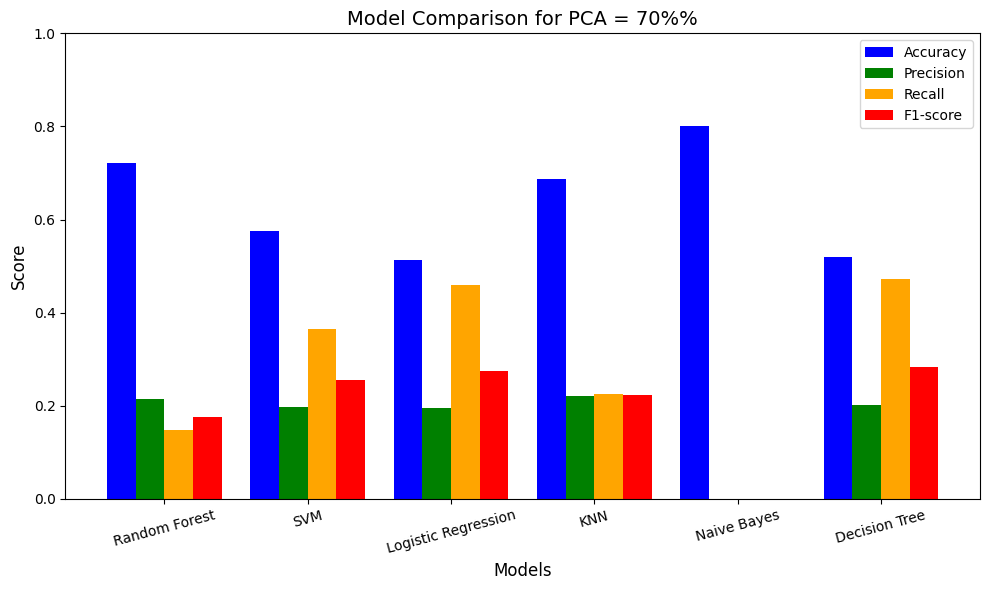

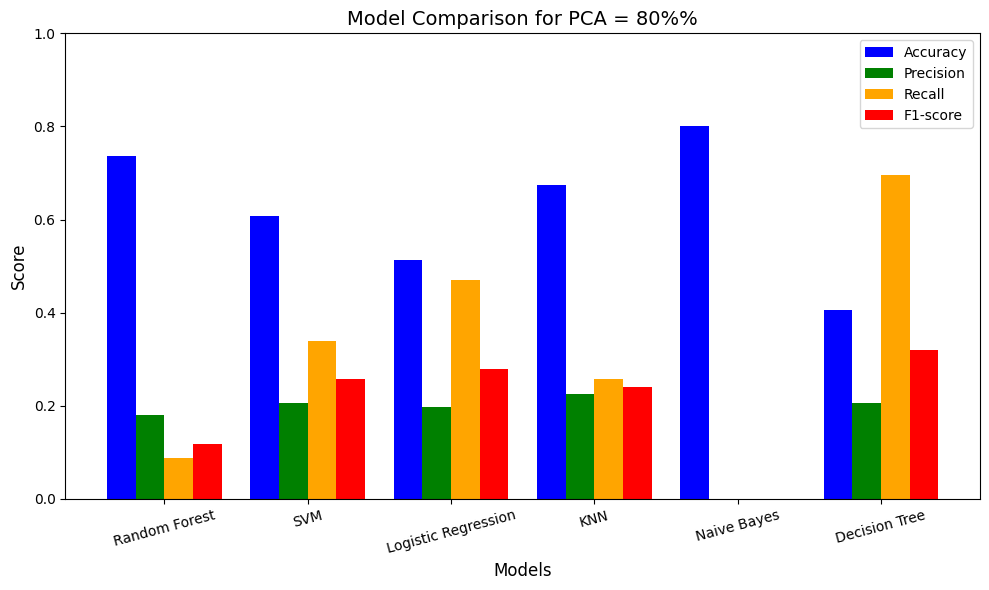

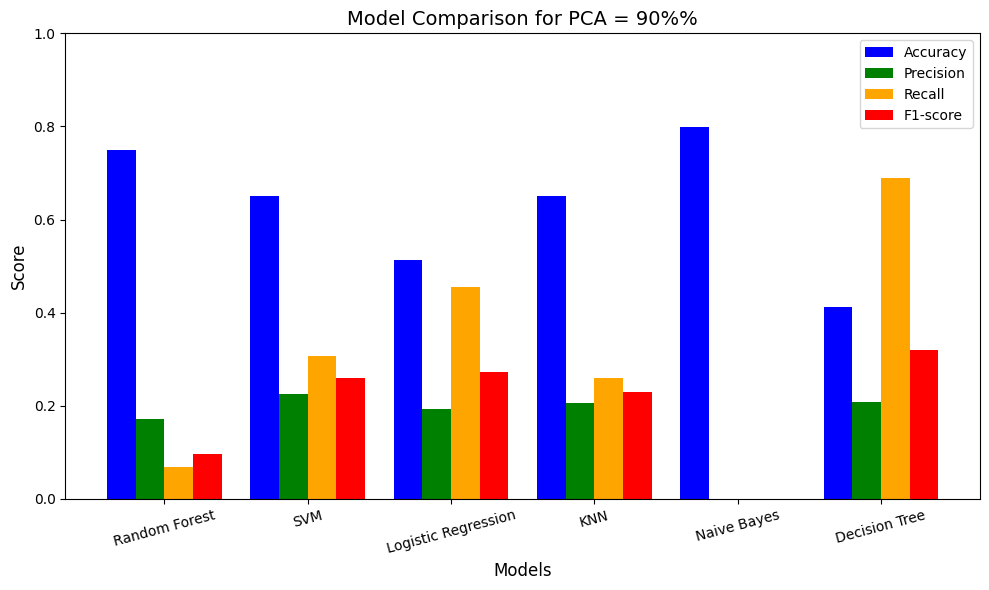

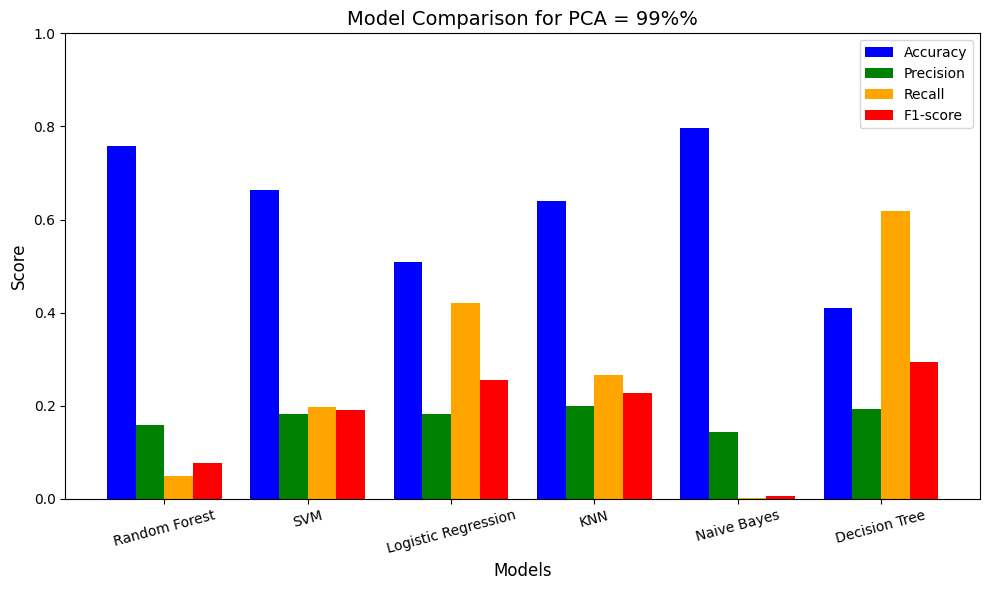

In [17]:
# ======================
# 1. Tổng hợp kết quả
# ======================
results_df = pd.DataFrame(results)

print("=== Comparison Table ===")
display(results_df.style.hide(axis="index"))

# ======================
# 2. Mô hình tốt nhất theo từng metric
# ======================
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
best_summary = []

for metric in metrics:
    idx = results_df[metric].idxmax()
    best_row = results_df.loc[idx]
    best_summary.append({
        'Metric': metric,
        'Best Model': best_row['Model'],
        'Best PCA': best_row['PCA'],
        'Best Score': best_row[metric]
    })

print("\n=== Best Model per Metric ===")
display(pd.DataFrame(best_summary).style.hide(axis="index"))

# ======================
# 3. Trực quan hóa kết quả theo từng mức PCA
# ======================
pca_values = sorted(results_df['PCA'].unique())
bar_width = 0.2

for pca in pca_values:
    df_pca = results_df[results_df['PCA'] == pca]

    models_compare = df_pca['Model'].values
    accuracy = df_pca['Accuracy'].values
    precision = df_pca['Precision'].values
    recall = df_pca['Recall'].values
    f1_score_vals = df_pca['F1-score'].values

    x = np.arange(len(models_compare))

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - 1.5*bar_width, accuracy, bar_width, label="Accuracy", color="blue")
    ax.bar(x - 0.5*bar_width, precision, bar_width, label="Precision", color="green")
    ax.bar(x + 0.5*bar_width, recall, bar_width, label="Recall", color="orange")
    ax.bar(x + 1.5*bar_width, f1_score_vals, bar_width, label="F1-score", color="red")

    ax.set_xlabel("Models", fontsize=12)
    ax.set_ylabel("Score", fontsize=12)
    ax.set_title(f"Model Comparison for PCA = {pca}%", fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(models_compare, rotation=15)
    ax.set_ylim(0, 1)
    ax.legend()
    fig.tight_layout()
    plt.show()

# **5. Kết luận**

Với bộ dữ liệu **Heart Disease** từ Kaggle, nhóm đã xây dựng và thử nghiệm một pipeline phân loại bệnh tim với nhiều mô hình khác nhau, kết hợp PCA và các tiêu chí đánh giá phổ biến. Kết quả cho thấy từng mô hình có ưu thế riêng, đồng thời khẳng định **Recall** là chỉ số quan trọng trong bối cảnh y tế nhằm hạn chế bỏ sót ca bệnh.  

Tham khảo:  
- [Heart Disease Prediction with 83.8% Accuracy](https://www.kaggle.com/code/hossainhedayati/heart-disease-prediction-with-83-8-accuracy)
